In [1]:
import sys
sys.path.append('../')
from src import mlp_quantile
from src import metrics as _metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns

sns.set(rc={'figure.figsize':(20,8)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
pd.set_option('display.max_rows', 120)

## Reading / Displaying the Data 

In [2]:
df_dataset_v2 = pd.read_csv('../data/forecast_dataset_exp14.csv')

In [3]:
df_dataset_v2.describe()

,month,unit_price,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,hc_cluster_6,hc_cluster_7,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,...,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,6.341538,236.499676,116.636923,0.120769,0.067692,0.064615,0.018462,0.000769,0.008462,0.001538,...,0.010769,0.005385,0.008462,0.064615,0.018462,0.018462,0.006154,0.008462,0.010000,0.013077
std,3.596290,216.022433,241.937405,0.325984,0.251314,0.245941,0.134665,0.027735,0.091632,0.039208,...,0.103254,0.073210,0.091632,0.245941,0.134665,0.134665,0.078235,0.091632,0.099537,0.113648
min,1.000000,6.910000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,113.246433,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,175.776013,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,288.258913,98.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,1903.950000,2063.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df_dataset_v2.head()

,code,year_month,month,unit_price,prod_code,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0671c2b9132a3f5215a4212ce0691694,2016-11,11,205.618941,0671c2b9132a3f5215a4212ce0691694,664,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0671c2b9132a3f5215a4212ce0691694,2016-12,12,245.817299,0671c2b9132a3f5215a4212ce0691694,225,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0671c2b9132a3f5215a4212ce0691694,2017-01,1,216.730145,0671c2b9132a3f5215a4212ce0691694,211,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0671c2b9132a3f5215a4212ce0691694,2017-02,2,206.905313,0671c2b9132a3f5215a4212ce0691694,634,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0671c2b9132a3f5215a4212ce0691694,2017-03,3,199.342329,0671c2b9132a3f5215a4212ce0691694,1343,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_cols = [c for c in df_dataset_v2.columns if c not in ['year_month', 'Y', 'prod_code'] and 'hc_cluster' not in c  ]

In [6]:
df_dataset_v2['code'] = df_dataset_v2['code'].astype('category').cat.codes

In [7]:
X_cols

['code',
 'month',
 'unit_price',
 'kmeans_cluster_0',
 'kmeans_cluster_1',
 'kmeans_cluster_2',
 'kmeans_cluster_3',
 'kmeans_cluster_4',
 'kmeans_cluster_5',
 'kmeans_cluster_6',
 'kmeans_cluster_7',
 'kmeans_cluster_8',
 'kmeans_cluster_9',
 'kmeans_cluster_10',
 'kmeans_cluster_11',
 'kmeans_cluster_12',
 'kmeans_cluster_13',
 'kmeans_cluster_14',
 'kmeans_cluster_15',
 'kmeans_cluster_16',
 'kmeans_cluster_17',
 'kmeans_cluster_18',
 'kmeans_cluster_19',
 'kmeans_cluster_20',
 'kmeans_cluster_21',
 'kmeans_cluster_22',
 'kmeans_cluster_23',
 'kmeans_cluster_24',
 'kmeans_cluster_25',
 'cat_code_0',
 'cat_code_1',
 'cat_code_2',
 'cat_code_3',
 'cat_code_4',
 'cat_code_5',
 'cat_code_6',
 'cat_code_7',
 'cat_code_8',
 'cat_code_9',
 'cat_code_10']

In [8]:
df_dataset_v2[X_cols].head()

,code,month,unit_price,kmeans_cluster_0,kmeans_cluster_1,kmeans_cluster_2,kmeans_cluster_3,kmeans_cluster_4,kmeans_cluster_5,kmeans_cluster_6,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0,11,205.618941,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,12,245.817299,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,216.730145,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,206.905313,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,199.342329,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting the Sets
* We will use the temporal series cross validation
* 3 months minimum intervals
* 3 training, 6 validation, 3 test
* 4 training, 5 validation, 3 test
* 5 training, 4 validation, 3 test
* 6 training, 3 validation, 3 test

In [9]:
df_train_val_test = pd.read_csv('../data/train_val_test.csv')

In [10]:
df_train_val_test

,set,train,val,reserved
0,0,"['2016-06', '2016-07', '2016-08']","['2016-09', '2016-10', '2016-11', '2016-12', '...",False
1,1,"['2016-06', '2016-07', '2016-08', '2016-09']","['2016-10', '2016-11', '2016-12', '2017-01', '...",False
2,2,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-11', '2016-12', '2017-01', '2017-02']",False
3,3,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-12', '2017-01', '2017-02']",False
4,4,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-01', '2017-02']",False
5,5,"['2016-06', '2016-07', '2016-08', '2016-09', '...",['2017-02'],False
6,6,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-03', '2017-04', '2017-05']",True


## Regressors Init

In [11]:
regressors = {}
RANDOM_STATE = 42
q =0.5

In [12]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(random_state=RANDOM_STATE)
regressors['gbm'] = gbm

In [13]:
import lightgbm as lgb
gbm_q = lgb.LGBMRegressor(alpha=q, objective = 'quantile',
    metric = 'quantile',random_state=RANDOM_STATE)
regressors['gbm_q'] = gbm_q

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
gb_q = GradientBoostingRegressor(loss='quantile', alpha=q)
regressors['gb_q'] = gb_q

In [15]:

# mlp_q = mlp_quantile.QuantileModel(input_dims=len(X_cols), q=q)
# regressors['mlp_q'] = mlp_q

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Train Eval



In [17]:
def parse_str_list(str_list):
    result = str_list.replace("'","").replace('[','').replace(']','').replace(' ', '').split(',')
    return result

In [18]:
sets = list(df_train_val_test[~df_train_val_test.reserved].set.values)
sets

[0, 1, 2, 3, 4, 5]

In [19]:
results = []
for r_name, r in regressors.items():
    for s in sets:
        df_set = df_train_val_test[~df_train_val_test.reserved & (df_train_val_test.set == s)]

        x_scaler = MinMaxScaler()
        
        train_years = parse_str_list(df_set.train.values[0])
        val_years = parse_str_list(df_set.val.values[0])
        print(f'Training {r_name} on set {s}')
        

        df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]
        df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    
        y_train = df_train['Y'].values    
        y_val = df_val['Y'].values
        
        if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
        else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
        print(f'Validating {r_name}  on set {s}')
        
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))
        
        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        results.append(m)

    print()
df_results = pd.DataFrame(results)    

Training gbm on set 0
Validating gbm  on set 0
Training gbm on set 1
Validating gbm  on set 1
Training gbm on set 2
Validating gbm  on set 2
Training gbm on set 3
Validating gbm  on set 3
Training gbm on set 4
Validating gbm  on set 4
Training gbm on set 5
Validating gbm  on set 5

Training gbm_q on set 0
Validating gbm_q  on set 0
Training gbm_q on set 1
Validating gbm_q  on set 1
Training gbm_q on set 2
Validating gbm_q  on set 2
Training gbm_q on set 3
Validating gbm_q  on set 3
Training gbm_q on set 4
Validating gbm_q  on set 4
Training gbm_q on set 5
Validating gbm_q  on set 5

Training gb_q on set 0
Validating gb_q  on set 0
Training gb_q on set 1
Validating gb_q  on set 1
Training gb_q on set 2
Validating gb_q  on set 2
Training gb_q on set 3
Validating gb_q  on set 3
Training gb_q on set 4
Validating gb_q  on set 4
Training gb_q on set 5
Validating gb_q  on set 5



In [20]:
metric_list = []

In [21]:
df_results.groupby('r_name').agg({'RMSE':[pd.Series.mean, pd.Series.std],
                                  'MDAPE':[pd.Series.mean, pd.Series.std],'MAPE':[pd.Series.mean, pd.Series.std],
                                  'MSE':[pd.Series.mean, pd.Series.std],
                                  'MAE':[pd.Series.mean, pd.Series.std],'R2':[pd.Series.mean, pd.Series.std],})

RMSE                MDAPE                MAPE            \
              mean        std      mean       std      mean       std   
r_name                                                                  
gb_q    177.907216  28.293984  0.630581  0.023059  2.115566  0.413268   
gbm     149.876393  21.154671  0.932070  0.090185  4.763787  0.996811   
gbm_q   188.201612  33.463616  0.729921  0.046441  2.846875  0.427295   

                 MSE                      MAE                   R2            
                mean           std       mean        std      mean       std  
r_name                                                                        
gb_q    32318.102015   9073.590248  77.094490  11.250110  0.414989  0.093030  
gbm     22835.866598   5950.693784  88.812935  10.010769  0.584014  0.055549  
gbm_q   36353.024665  11444.579418  84.987427  10.362689  0.345381  0.127505

Training gbm on set 6
Validating gbm on set 6 and 2017-03
932 125
RMSE : 132.7913
MAPE': 2.4187
MDAPE': 0.7857
MSE: 17633.5360
MAE: 66.1120
R2: 0.6863


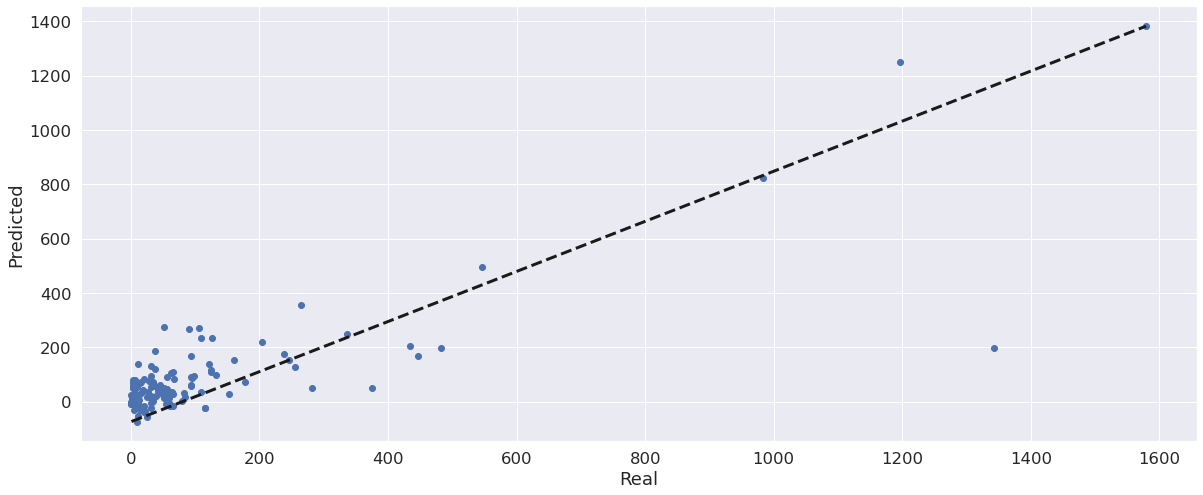

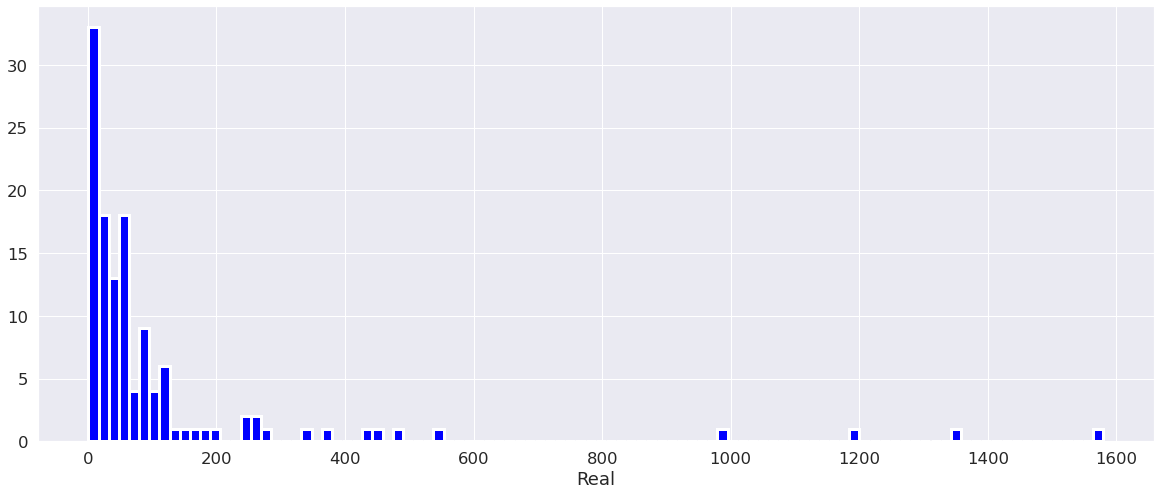

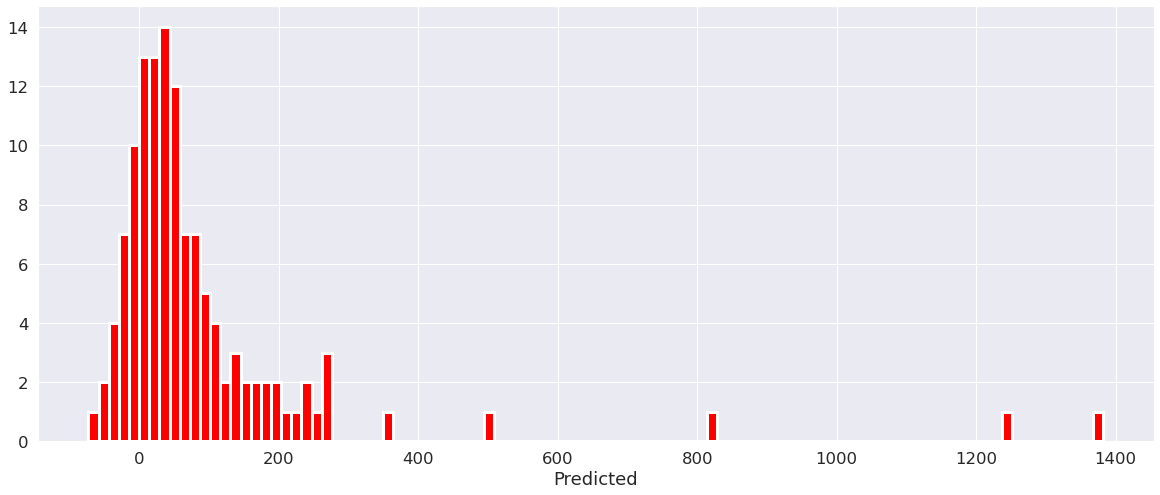


Validating gbm on set 6 and 2017-04
932 122
RMSE : 114.2734
MAPE': 3.0634
MDAPE': 0.6691
MSE: 13058.4016
MAE: 65.0082
R2: 0.7330


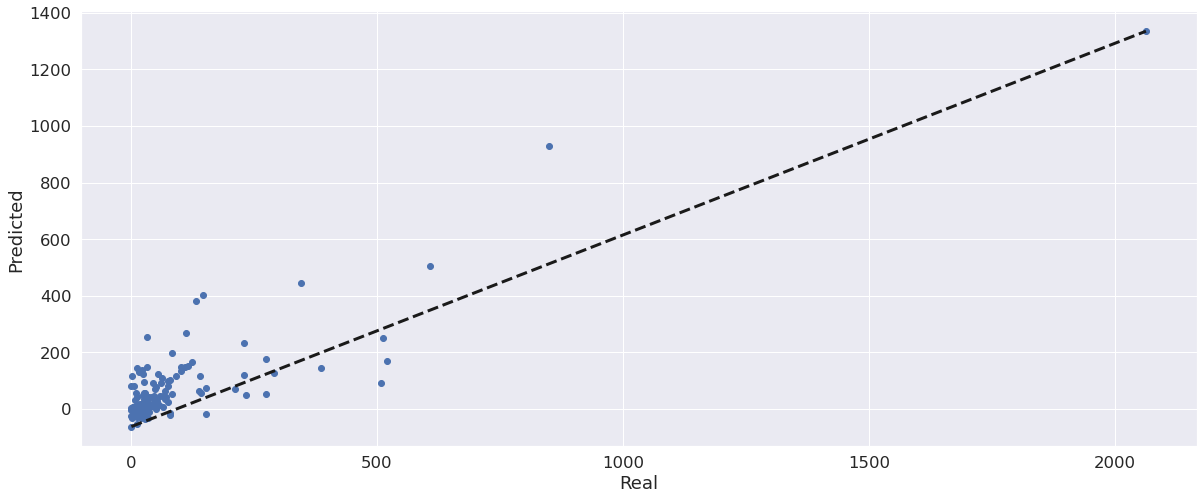

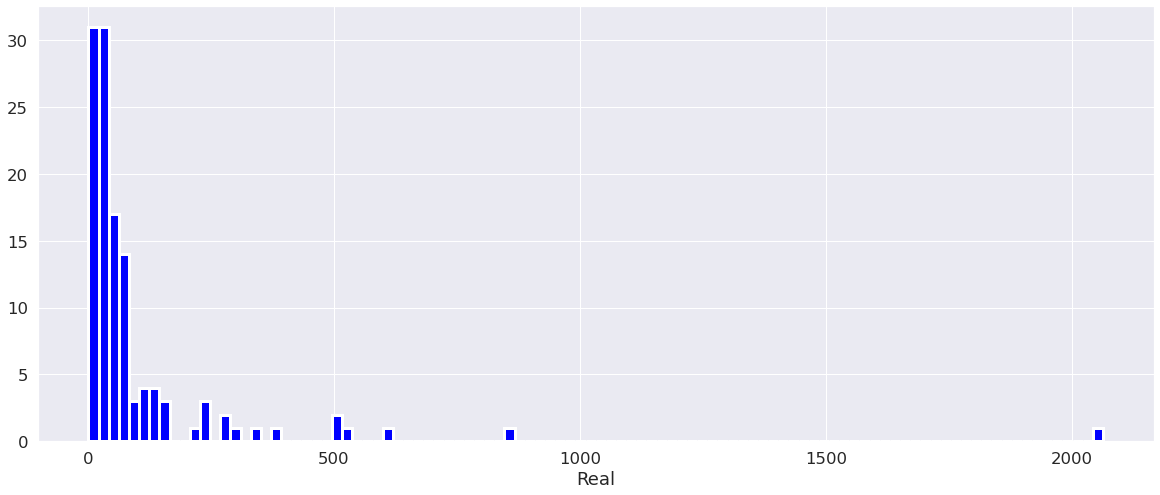

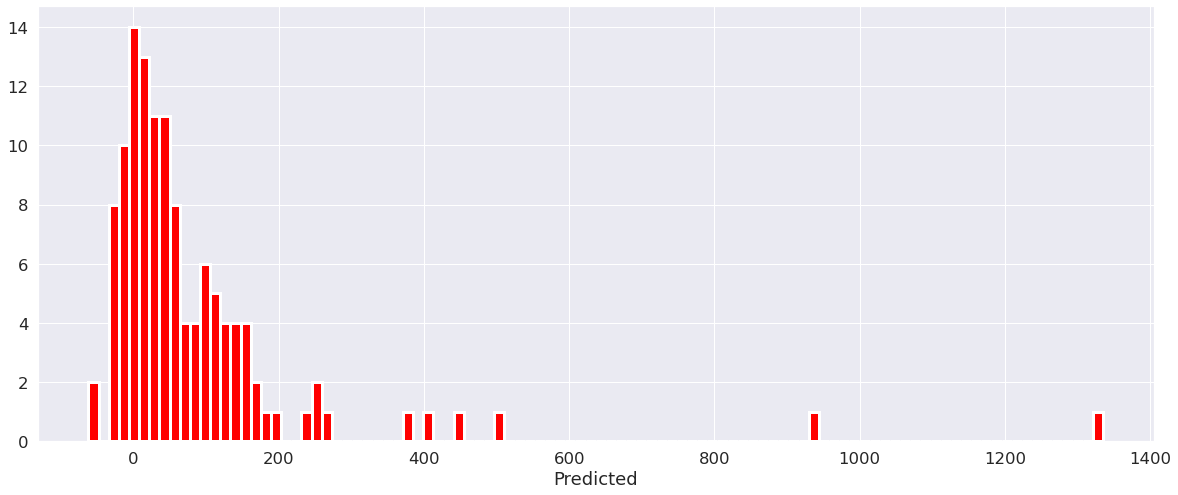


Validating gbm on set 6 and 2017-05
932 121
RMSE : 161.3785
MAPE': 1.9091
MDAPE': 0.7460
MSE: 26043.0083
MAE: 90.8264
R2: 0.6507


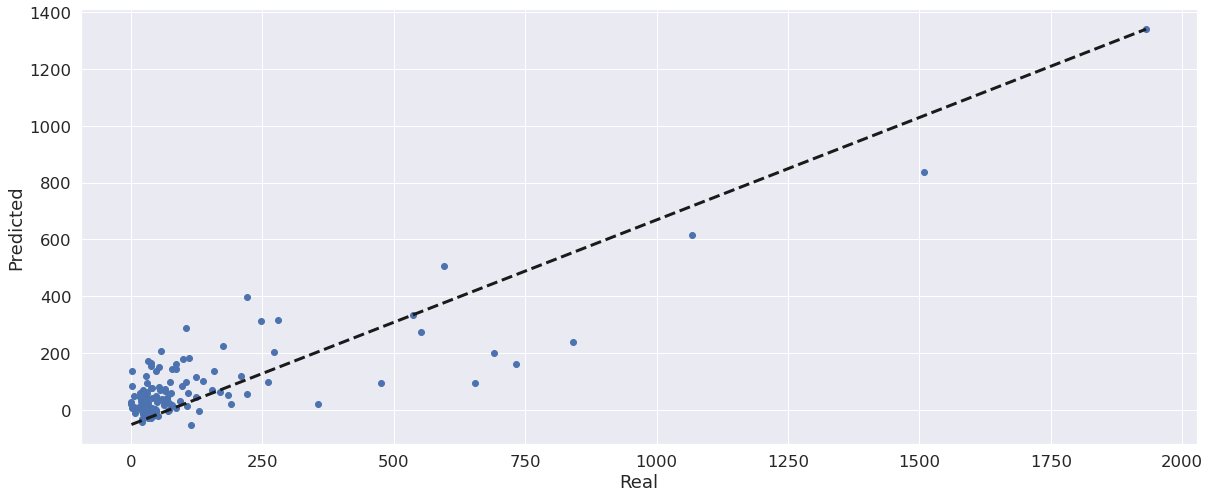

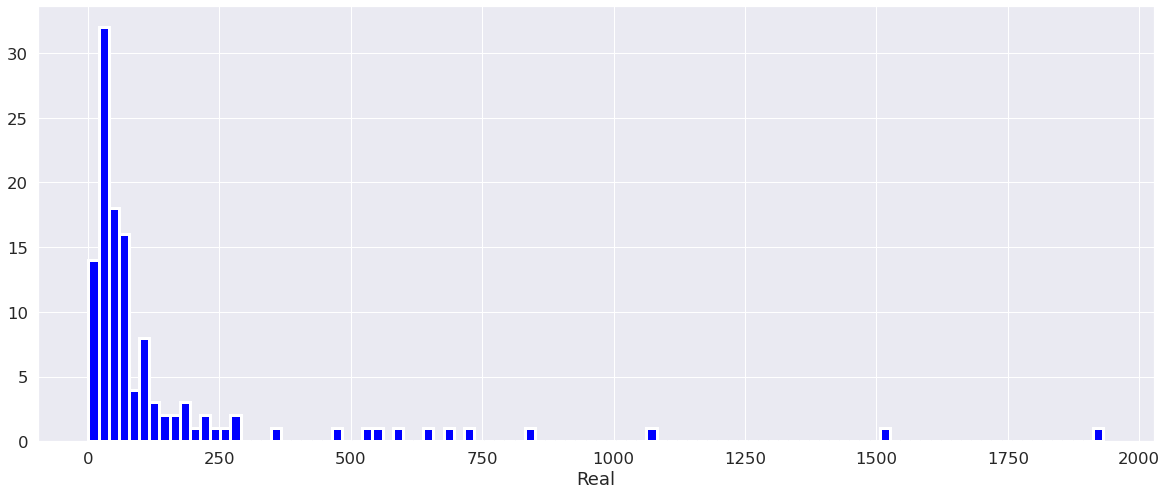

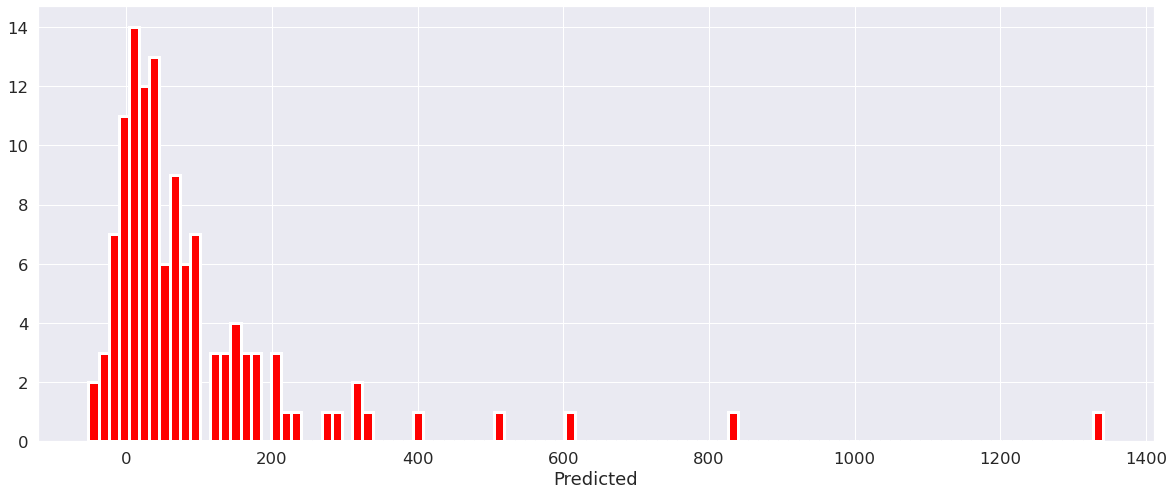


Training gbm_q on set 6
Validating gbm_q on set 6 and 2017-03
932 125
RMSE : 165.6987
MAPE': 2.0162
MDAPE': 0.5600
MSE: 27456.0480
MAE: 67.5040
R2: 0.5115


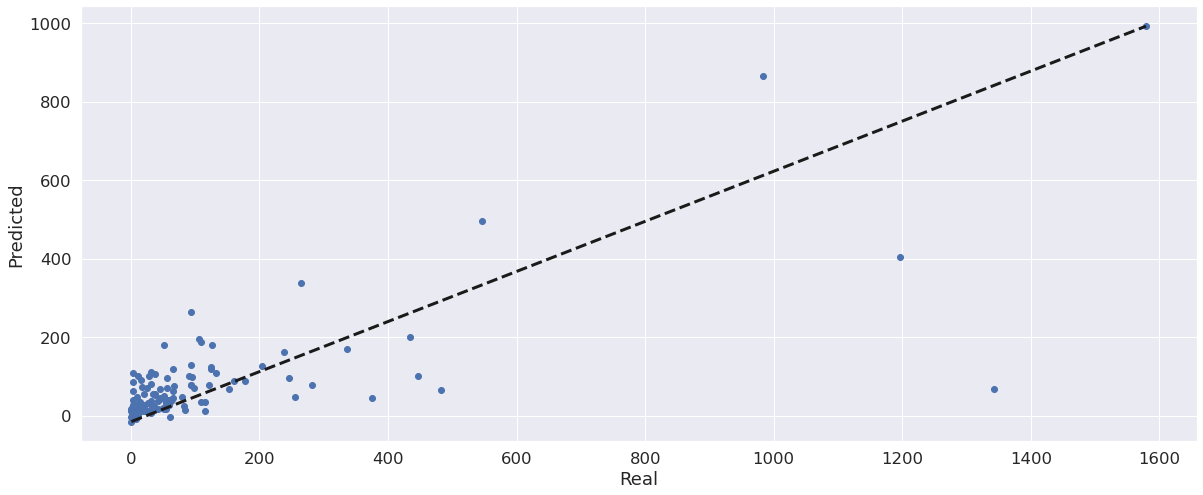

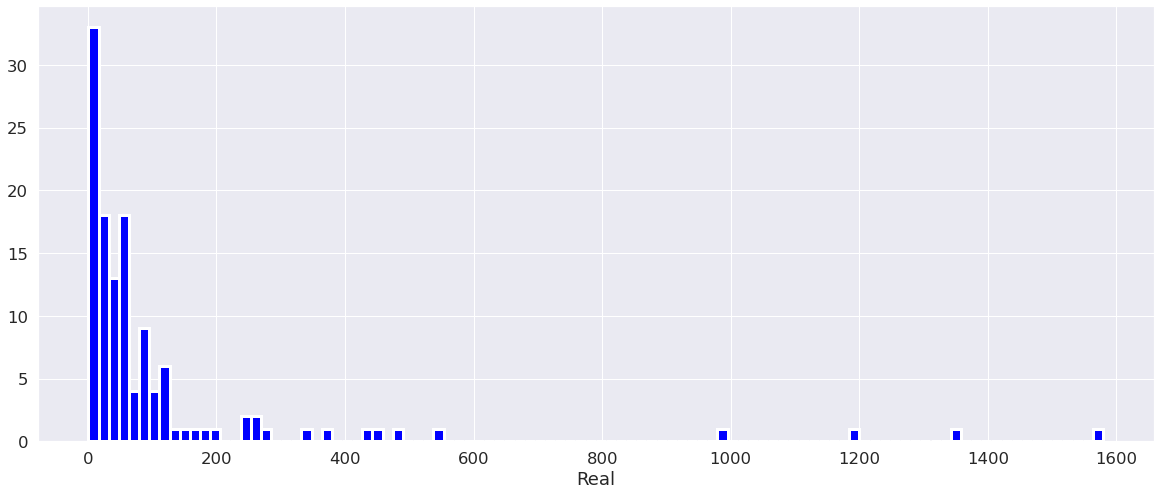

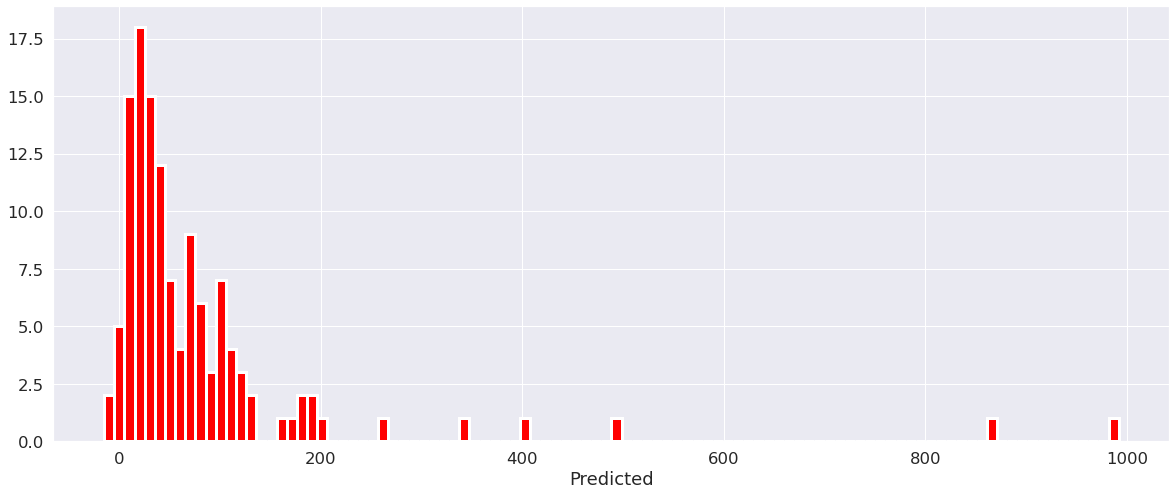


Validating gbm_q on set 6 and 2017-04
932 122
RMSE : 152.2410
MAPE': 1.6982
MDAPE': 0.5993
MSE: 23177.3197
MAE: 67.3033
R2: 0.5261


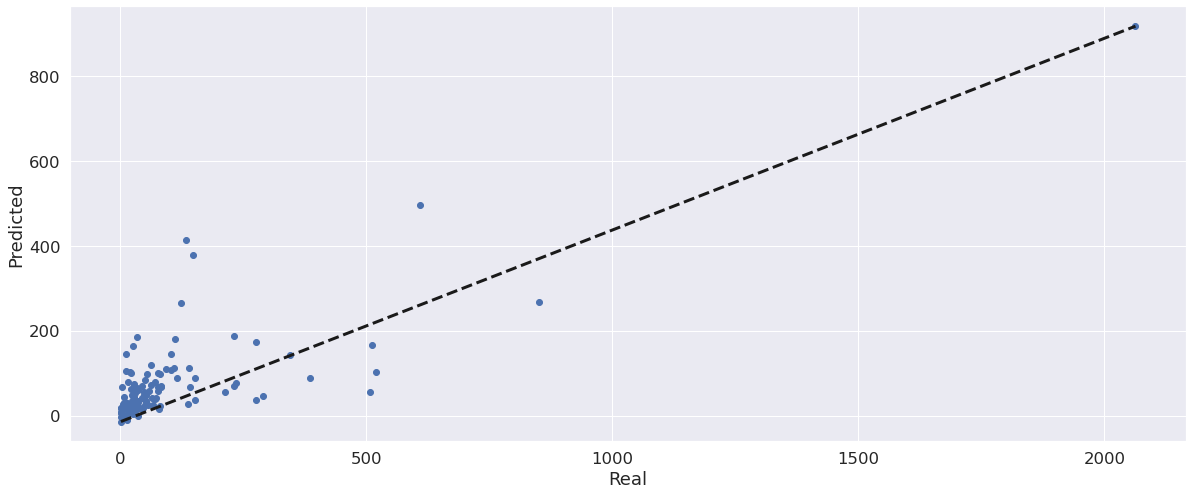

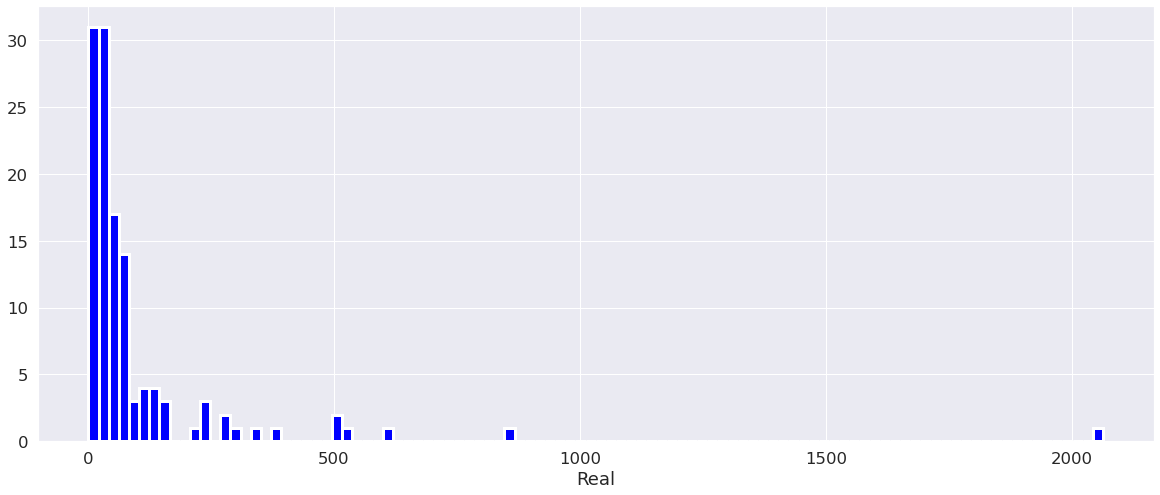

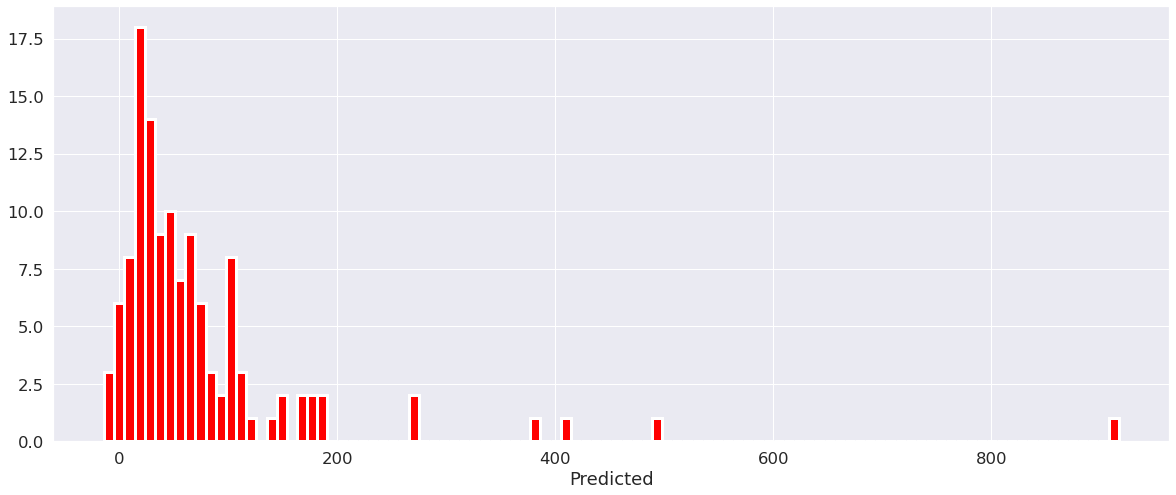


Validating gbm_q on set 6 and 2017-05
932 121
RMSE : 202.5930
MAPE': 0.8569
MDAPE': 0.6102
MSE: 41043.9091
MAE: 90.7686
R2: 0.4495


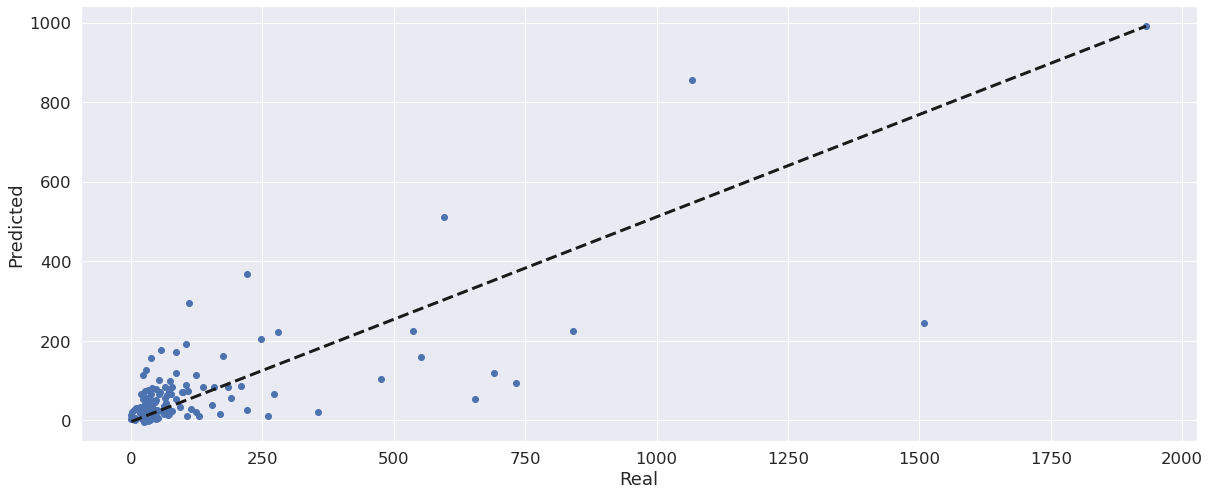

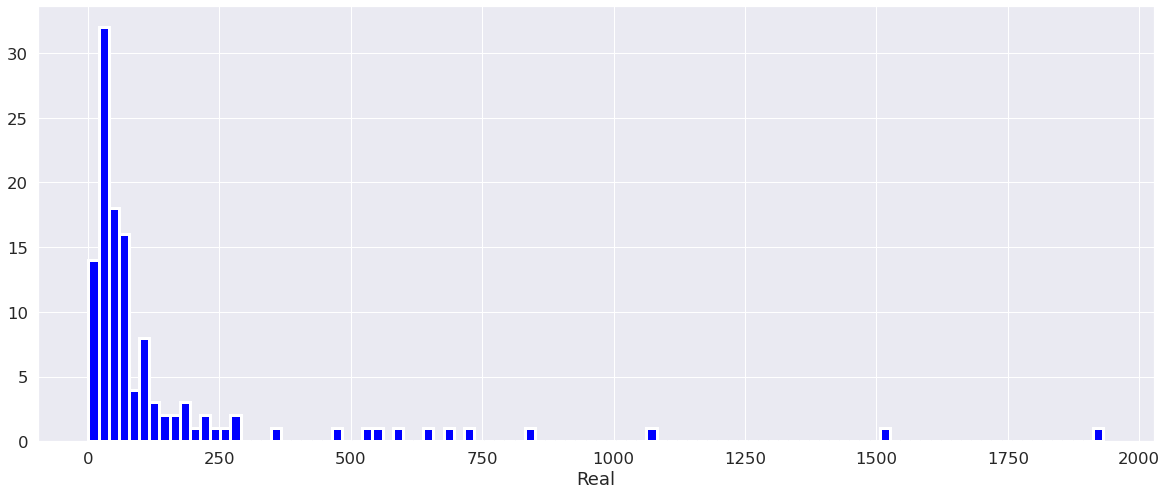

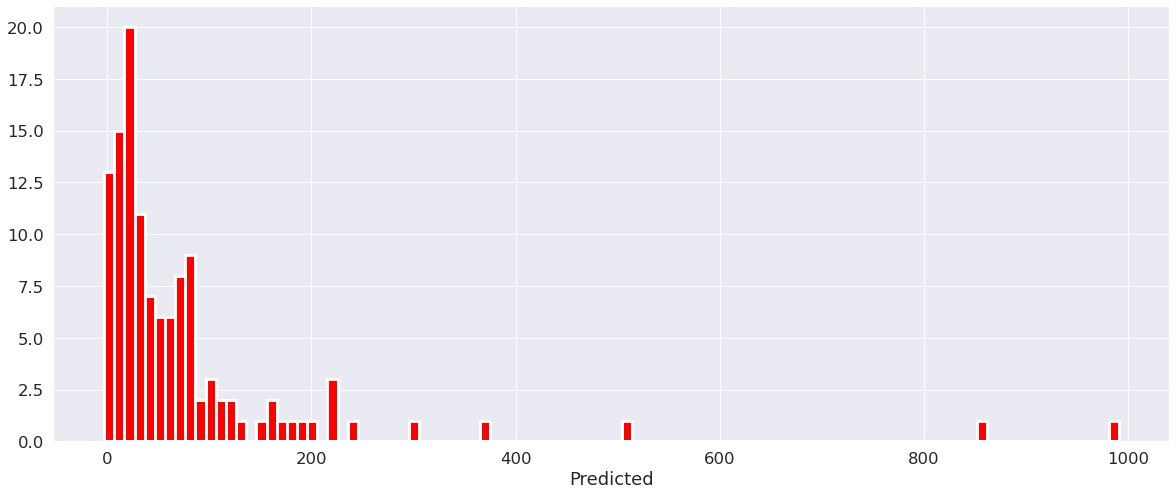


Training gb_q on set 6
Validating gb_q on set 6 and 2017-03
932 125
RMSE : 197.8580
MAPE': 2.1500
MDAPE': 0.6207
MSE: 39147.8000
MAE: 80.1040
R2: 0.3035


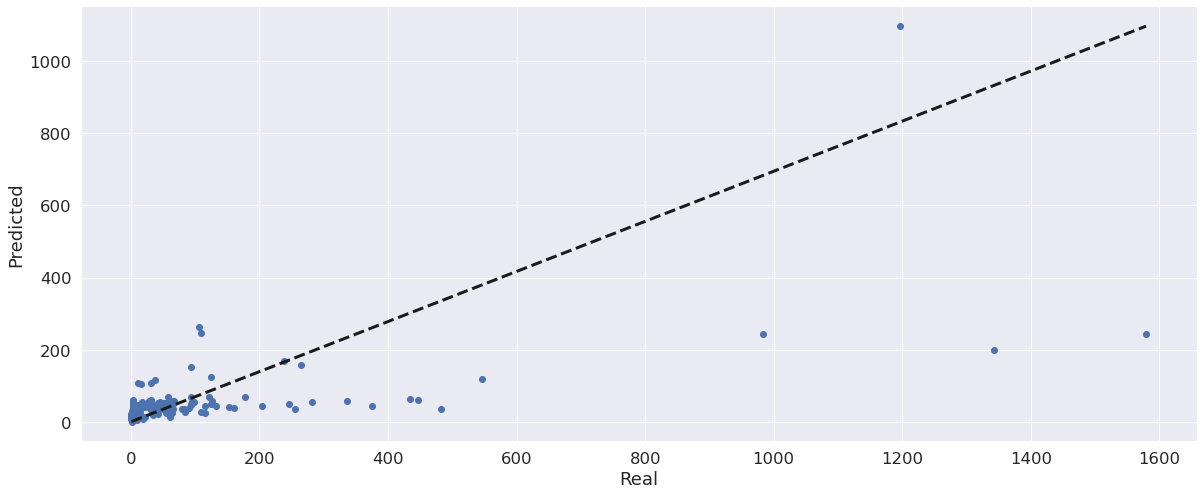

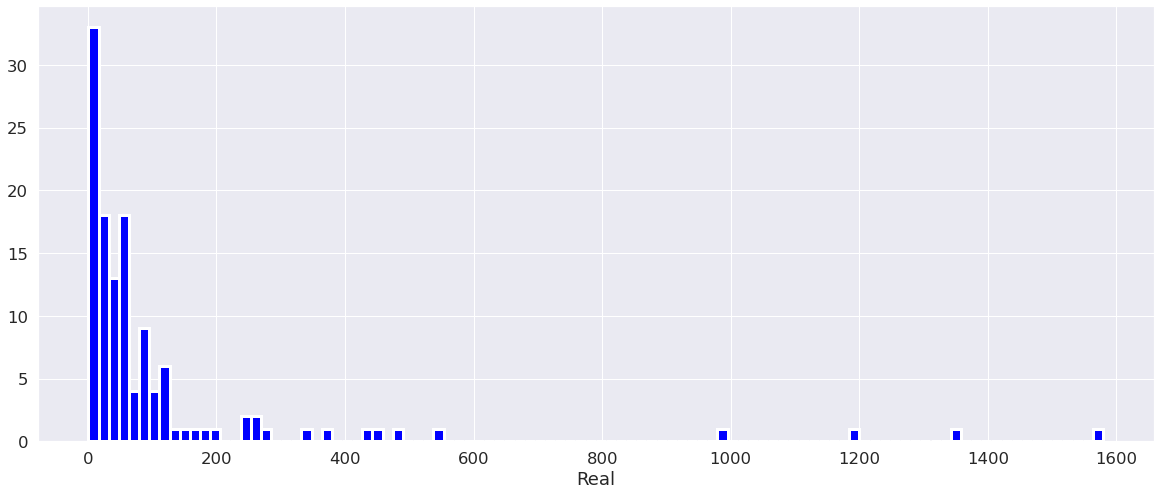

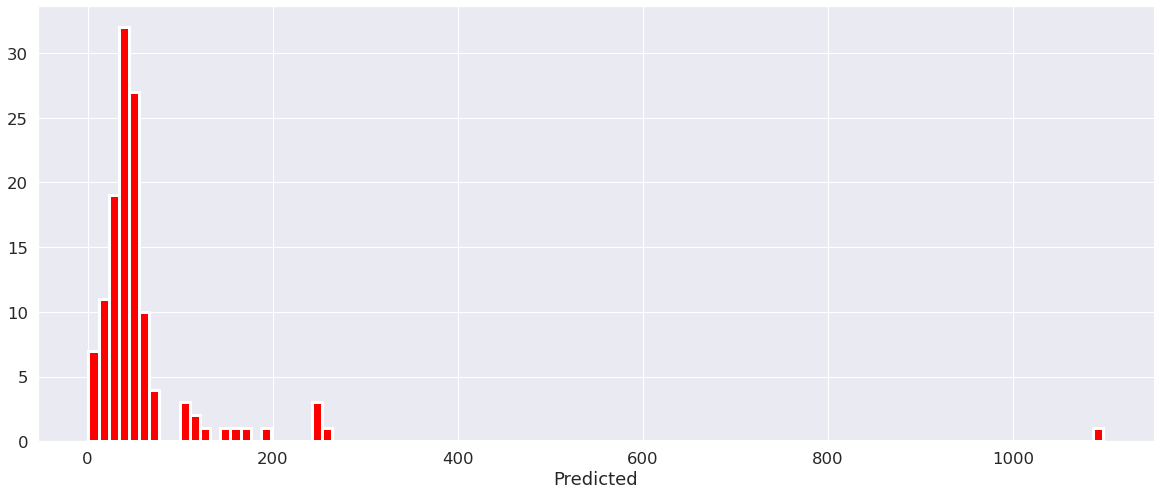


Validating gb_q on set 6 and 2017-04
932 122
RMSE : 195.4472
MAPE': 1.4731
MDAPE': 0.5312
MSE: 38199.6148
MAE: 68.9426
R2: 0.2190


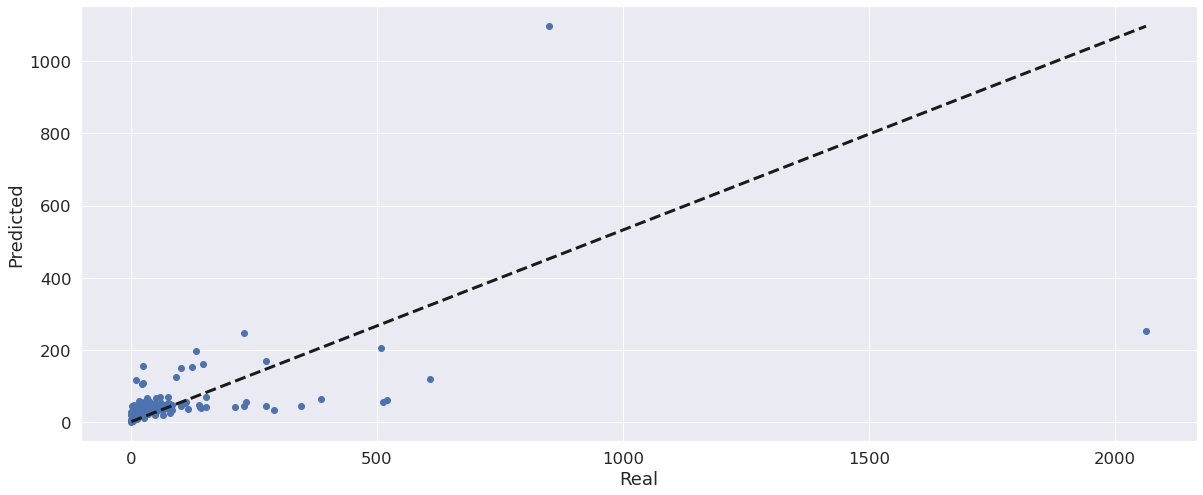

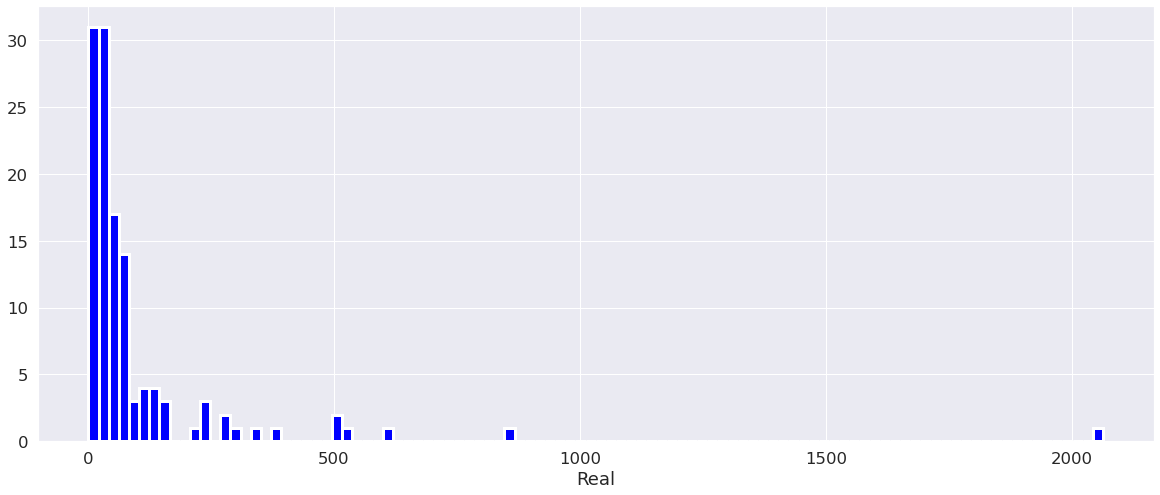

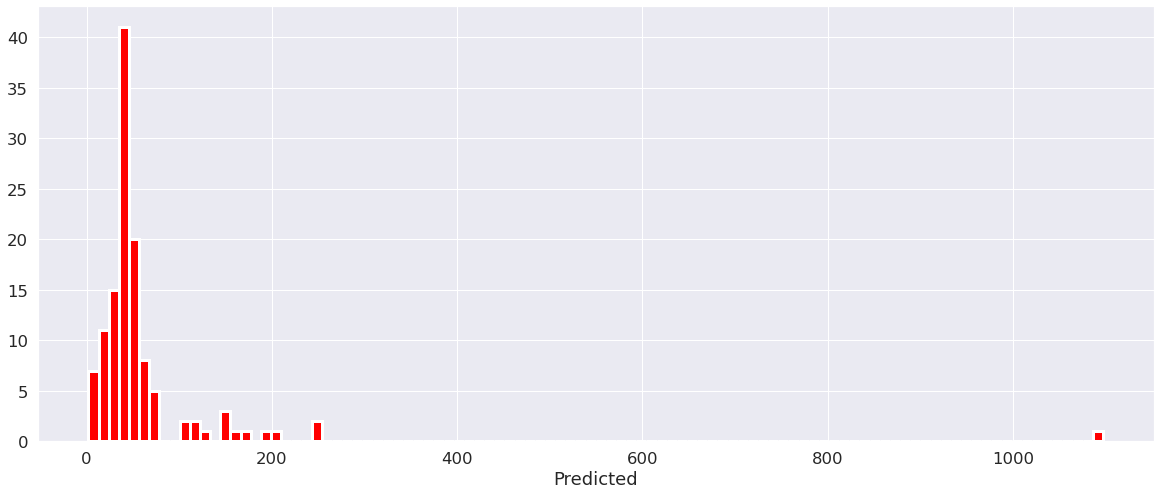


Validating gb_q on set 6 and 2017-05
932 121
RMSE : 233.5120
MAPE': 1.0145
MDAPE': 0.5000
MSE: 54527.8430
MAE: 96.7355
R2: 0.2686


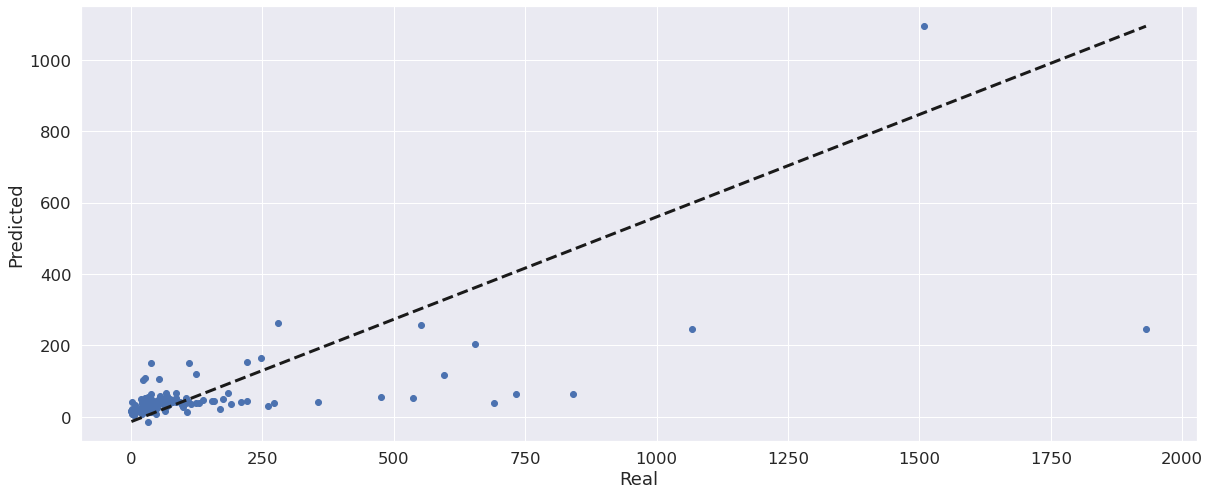

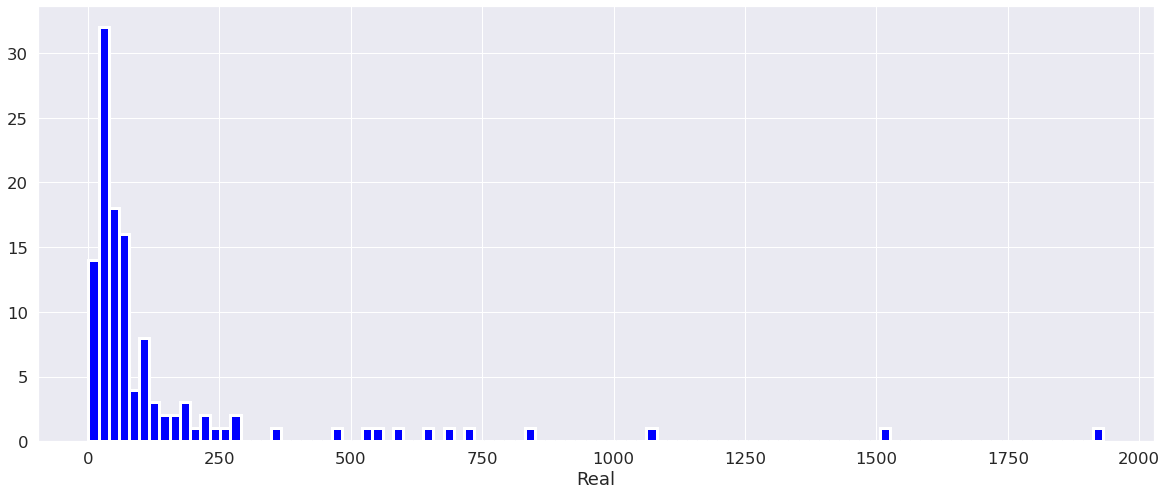

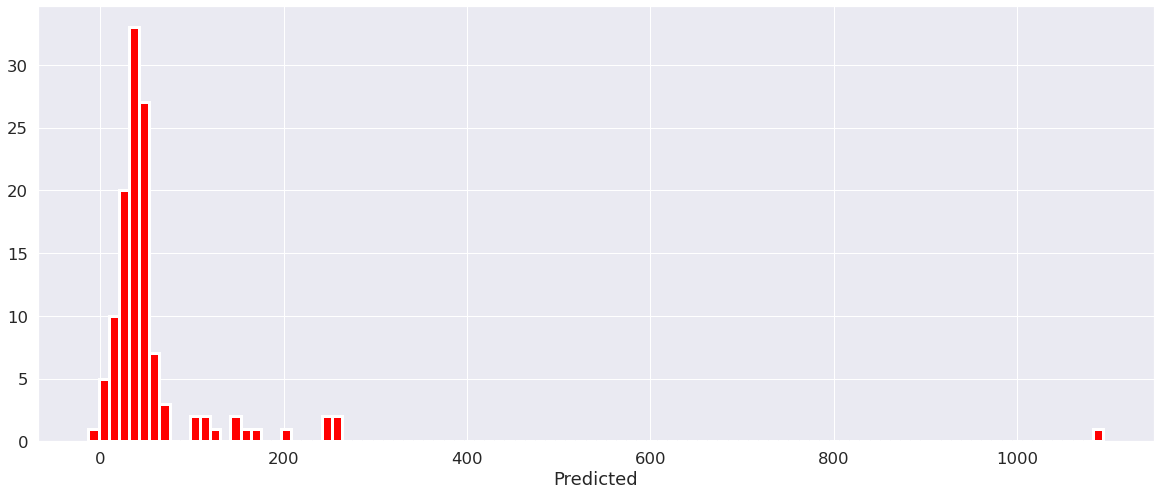

In [22]:
results = []
for r_name, r in regressors.items():
    s=6
    x_scaler = StandardScaler()

    df_set = df_train_val_test[(df_train_val_test.set == s)]

    x_scaler = MinMaxScaler()

    train_years = parse_str_list(df_set.train.values[0])
    val_years = parse_str_list(df_set.val.values[0])
    print(f'Training {r_name} on set {s}')

    df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]    

    y_train = df_train['Y'].values    
    df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    y_val = df_val['Y'].values
        
    if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
    else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
    for val_year in val_years:
        df_val = df_dataset_v2[df_dataset_v2.year_month == val_year]
        print(f'Validating {r_name} on set {s} and {val_year}')
        y_val = df_val['Y']
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))

        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        m['year_month'] = val_year
        results.append(m)
        print(len(y_train), len(y_val))
        _metrics.evaluateRegression(y=y_val, y_pred=y_pred_val)
        print()
df_results = pd.DataFrame(results)    

In [23]:
df_results[[c for c in df_results.columns if  c not in ['y', 'y_pred']]].sort_values('year_month')

,RMSE,MAPE,MDAPE,MSE,MAE,R2,reg_inst,r_name,set,year_month
0,132.791325,2.418654,0.785714,17633.536000,66.112000,0.686289,LGBMRegressor(random_state=42),gbm,6,2017-03
3,165.698666,2.016183,0.560000,27456.048000,67.504000,0.511541,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-03
6,197.858030,2.149980,0.620690,39147.800000,80.104000,0.303539,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-03
1,114.273364,3.063446,0.669086,13058.401639,65.008197,0.733008,LGBMRegressor(random_state=42),gbm,6,2017-04
4,152.240992,1.698215,0.599327,23177.319672,67.303279,0.526117,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-04
7,195.447217,1.473068,0.531205,38199.614754,68.942623,0.218971,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-04
2,161.378463,1.909141,0.746032,26043.008264,90.826446,0.650696,LGBMRegressor(random_state=42),gbm,6,2017-05
5,202.592964,0.856889,0.610169,41043.909091,90.768595,0.449495,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-05
8,233.511976,1.014524,0.500000,54527.842975,96.735537,0.268640,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-05
